# Breweries Pipeline
* Remove observations with '`NA`'
* Remove observations with Brewery Score of `0`
* Convert numeric values to `float`
* Convert categorical columns
    * Convert `Brewery_Type` to four new columns containing booleans for:
        * `Bar`
        * `Eatery`
        * `Homebrew`
        * `Beer-to-go`
* Create boolean from notes column indicating whether Brewery has notes
* Drop unnecessary columns
    * `Brewery_Notes`
    * `Brewery_Type`
    * `Brewery_Class`
    * `pDev` - this is the percent deviation of the scores i.e. results from the score and cannot be used as a predictor.
    
## Beers
* Import and concatenate beer style dfs
* Remove `'Brewery_Num'` and `'Beer_Name`' as they are not necessary for analysis
* Convert `'ABV'` and `'Beer_Score'` to `float` and `'Num_Beer_Ratings'` to `int`
#### Add the following columns:
* Total Number of Beer Reviews
* Standard deviation of alcohol content
* Number of Beer_Style produced by a brewery
* Average Beer_Score by Brewery
* Average Alcohol content of beers
* Highest average score for a style
* Lowest average score for a style  
* Max/min/mean beer score by style category


* Imputing missing ABV Values (Not really necessary...)


* Highest/Lowest score for any beer for a brewery
* Number of beers within particular styles
* Number of beers within style groups


#### Later add
* Percentage of beers by beer style
* Average number of beers by style (only counting styles that have at least one beer)
* average number of ratings by beer style (Num ratings doesn't seem to be a good indicator)
* max number of ratings by beer style (Num ratings doesn't seem to be a good indicator)

## Desired Columns:
* Create boolean for each beer whether notes exists.
    * Possibly convert to percentage of beers that have notes
    * Could also have total beers with notes (boolean probably better)

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as snsm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

In [2]:
os.chdir('Data2/')

# Breweries

In [97]:
brews_df = pd.read_pickle('breweries_with_loc')
brews_df.reset_index(inplace=True)
brews_df.columns = ['Brewery_Name','Score', 'Brewery_Class', 'Num_Beers', 
                    'Town', 'State', 'Country', 'Total_Beer_Reviews', 
                    'Total_Beer_Ratings', 'Brewery_Score', 
                    'Num_Brewery_Reviews', 'Num_Brewery_Ratings', 
                    'pDev', 'Brewery_Type', 'Has_Phone', 'Brewery_Notes']

##### Looking at our data

``` python 
i = 0 
while i < 15:
    print(brews_df.iloc[:,i].value_counts())
    i += 1 
    ```

### Removing rows with `'NA'` values

This reduces the number of entries from ????? to 8630. Close to a 50% reduction. While it is unfortunate to lose such a significant portion of a dataset, **all????** of the observations that were removed did not contain a Brewery Score and thus would help in neither training nor testing of the model.

Convert to `'NA'` to `np.nan` 

In [98]:
brews_df.replace('NA',np.nan,inplace=True)
brews_df.dropna(inplace=True)

### Removing rows with Score of zero

In addition to removing Breweries with no score, we've also removed Breweries with a score of zero as they were a clear outlier within the distribution. I believe that Breweries which have yet to receive any reviews either had no value ('NA') or a value of zero. This reduced the total number of Breweries in the dataset to 8153.

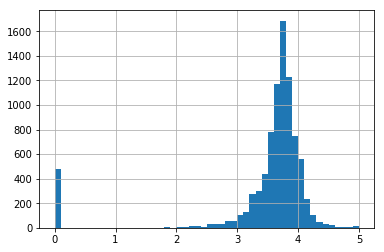

In [99]:
brews_df['Score'] = brews_df['Score'].apply(float)
brews_df['Score'].hist(bins = 50);

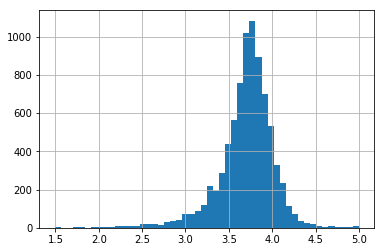

In [100]:
brews_df.replace(0,np.nan,inplace=True)
brews_df.dropna(inplace=True)
brews_df['Score'].hist(bins = 50);

### Convert remaining values to numeric where applicable

### Convert Categorical Columns

##### Convert b_type (Brewery Type) to dummies

The assumption in converting Brewery Type to dummies is that the functionality of the brewery, meaning whether one can eat there (i.e. is it also a restaurant) whether they have a bar, etc., may correlate to their score. It is also possible that the particular functionality might be irrelevant and that simply having greater functionality may boost the score (or even reduce it). In such a case we could take the sum of the newly created `'Bar'`, `'Eatery'`, `'Homebrew'`, and `'Beer-to-go'` columns.  
Note that we do not use `.get_dummies()` as it is possible for a brewery to be both a bar, eatery, etc. 

In [101]:
brews_df['Bar'] = brews_df.Brewery_Type.str.contains('Bar')
brews_df['Eatery'] = brews_df.Brewery_Type.str.contains('Eatery')
brews_df['Homebrew'] = brews_df.Brewery_Type.str.contains('Homebrew')
brews_df['Beer_to_go'] = brews_df.Brewery_Type.str.contains('Beer-to-go')

Creating a column containing a boolean value indicating whether a Brewery has notes on their brewery page within Beer Advocate. I believe this may have an impact on a Brewery's score as people may go onto a Brewery's page to research. Some Breweries may indicate hours (or days) of operation. Having a description can help reduce potential points of friction in a customer's relationship with a Brewery thus leading to the customer giving the Brewery a higher score.

In [102]:
brews_df['Has_Notes'] = brews_df.Brewery_Notes.str.contains('No notes at this time.')
brews_df.drop(['Brewery_Notes','Brewery_Type','Brewery_Class','pDev','Brewery_Score'],inplace=True,axis=1)

Note that we'll leave the Brewery_Name column for now as it will be used to join the beer data with the brewery data.

### Convert column  types

In [103]:
brews_df.Score = brews_df.Score.apply(float)
brews_df.Num_Beers = brews_df.Num_Beers.apply(int)
brews_df.Total_Beer_Ratings = brews_df.Total_Beer_Ratings.apply(int)
brews_df.Total_Beer_Reviews = brews_df.Total_Beer_Reviews.apply(int)
brews_df.Num_Brewery_Ratings = brews_df.Num_Brewery_Ratings.apply(int)
brews_df.Num_Brewery_Reviews = brews_df.Num_Brewery_Reviews.apply(int)
brews_df.Has_Phone = brews_df.Has_Phone.astype(np.int32)
brews_df.Bar = brews_df.Bar.astype(np.int32)
brews_df.Eatery = brews_df.Eatery.astype(np.int32)
brews_df.Homebrew = brews_df.Homebrew.astype(np.int32)
brews_df.Beer_to_go = brews_df.Beer_to_go.astype(np.int32)
brews_df.Has_Notes = brews_df.Has_Notes.astype(np.int32)

### Sum of Brewery_Type columns
From this we can deduce whether there's a correlation between greater versatility at a brewery and their Score.

In [104]:
brews_df['Brewery_Style_Total'] = brews_df[['Bar','Eatery','Homebrew','Beer_to_go']].sum(axis=1)

### Plotting Correlations

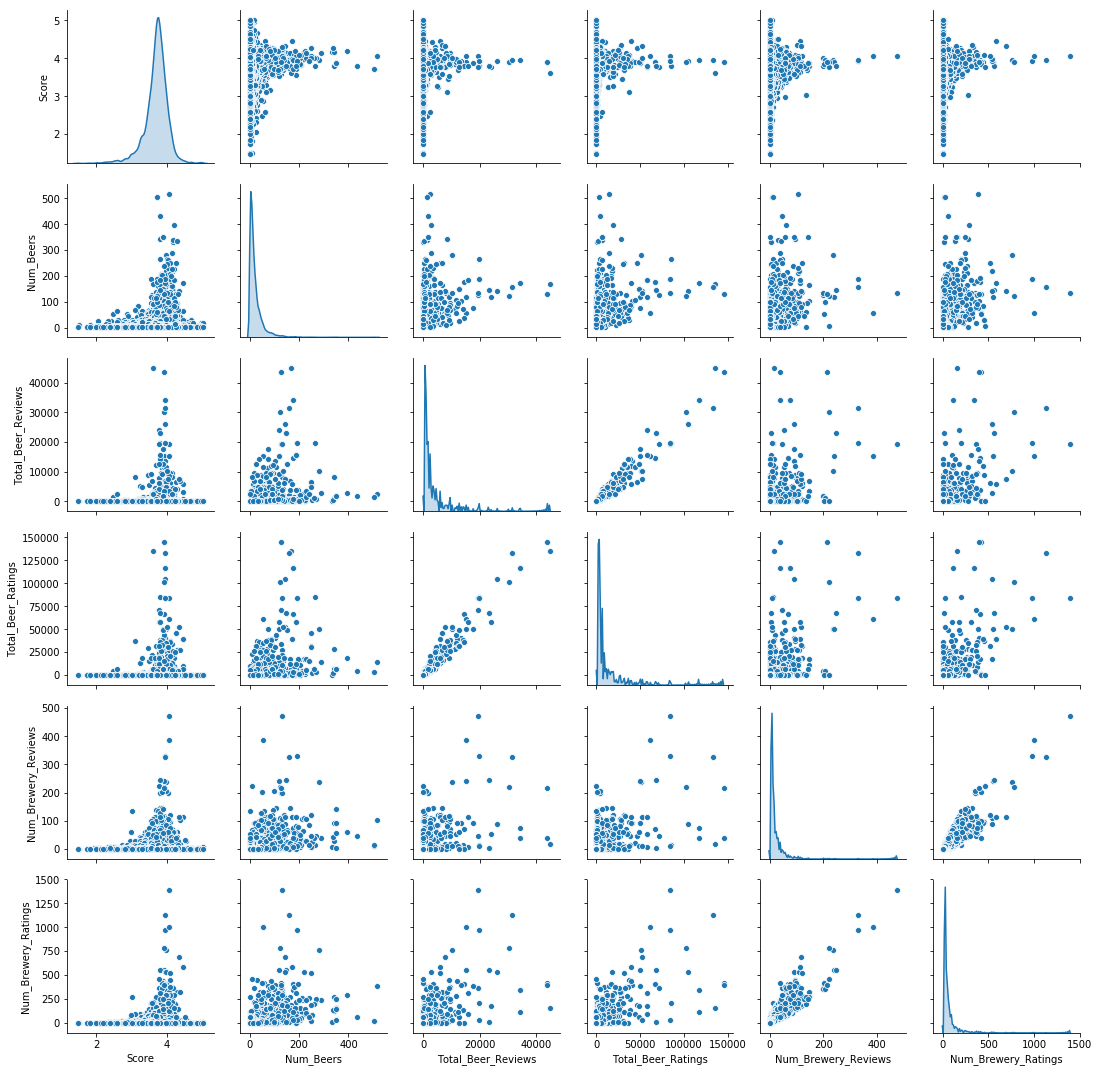

In [11]:
sns.pairplot(brews_df.iloc[:,0:10],diag_kind='kde');

In [12]:
brews_corr = brews_df.corr()

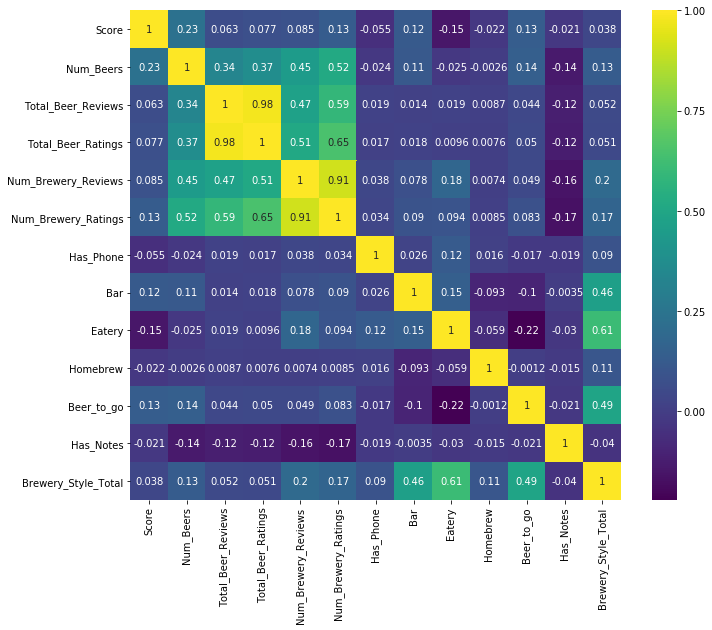

In [13]:
plt.figure(figsize=(11,9))
sns.heatmap(brews_corr,cmap='viridis',annot=True);

As you can see above, a Brewery's score is not impacted significantly by any of the characteristics listed on the Brewery's page on Beer Advocate. `Num_Beers` has the most significant correlation at `.23` but that is more a question of the Brewery's output/overall presense on beer advocate rather than a attribute of their profile. An attribute of their profile such as wether or not they include their phone number has almost zero correlation.   
The next most significant correlations are `Eatery`, `Num_Brewery_Ratings`, `Beer_to_go`, and `Bar` at only `-.15`, `.13`, `.13`, and `.12` respectively. From this we can tentatively assume that having a greater number of ratings for beers on Beer Advocate (although, note that it is not a critical component) and the ability to purchase beer-to-go (i.e. buy a 6-pack from a Brewery, not necessarily just drink at a bar within the brewery) will result in a slightly higher score, while serving food (`Eatery`) will lead to a lower score.  
Perhaps those who use Beer Advocate hold something against breweries that serve food?

### Drop weakest correlating Columns

In [14]:
brews_df.drop(['Total_Beer_Reviews','Total_Beer_Ratings','Num_Brewery_Reviews','Has_Phone','Homebrew','Has_Notes','Brewery_Style_Total'],inplace=True,axis=1)

### Testing whether strongest correlating columns are random

### Testing Geographic Correlations

### Assigning Brewery_Name to index

In [16]:
brews_df.set_index('Brewery_Name',inplace=True)

# Beers

### Import and concatenate Beer Style Dataframes

The below was used to open all files that were saved to the Data2/ folder. Columns were renamed to be consistent with the convention used in brews_df.

``` python
data_fols = os.listdir()

style_nums = []

for fol in data_fols:
    try:
        int(fol)
        style_nums.append(str(fol))
    except:
        pass

beers_df = pd.DataFrame(columns = ['beer_name','brewery_name','abv',
                             'ratings','score','brewery_nums'])

for num in style_nums:
    pickled = pd.read_pickle(num)
    beers_df = pd.concat([beers_df,pickled],sort=True)
    
beers_df.columns = ['ABV','Beer_Name','Brewery_Name',
                    'Brewery_Num','Num_Beer_Ratings',
                    'Beer_Score','Beer_Style']
    
pd.to_pickle(beers_df,'Beer_Data')

```

In [3]:
beers_df = pd.read_pickle('Beer_Data')

Drop the Brewery_Num column as those values would have only been necessary to populate the Brewery Scraper function and will not be used in our model.

### Drop unnecessary columns

In [4]:
beers_df.drop(['Brewery_Num','Beer_Name'],inplace=True,axis=1)

Remove extraneous characters from `'ABV'` and `'Num_Beer_Ratings'` columns. Convert `'ABV'` and `'Beer_Score'` to `float` and `'Num_Beer_Ratings'` to `int`.

### Convert numeric columns to float and int

In [5]:
beers_df['ABV'].replace(' ? ',np.nan,inplace=True)
beers_df.Num_Beer_Ratings = beers_df.Num_Beer_Ratings.str.replace(',','')

beers_df.ABV = beers_df.ABV.apply(float)
beers_df.Beer_Score = beers_df.Beer_Score.apply(float)
beers_df.Num_Beer_Ratings = beers_df.Num_Beer_Ratings.apply(int)

Convert/impute missing values within ABV to the mean of ABV for that Beer_Style.  
I decided to use the mean instead of the median due to the fact that the distribution of alcohol percentages by beer style are roughly normal but values peak around around certain values, typically integers. As it was possible for the median to fall within some of these peaks around integers, I decided that the mean is likely a more accurate representation of central tendency.

### Add Total Number of Beer Reviews

In [12]:
total_beer_ratings = beers_df.groupby('Brewery_Name').sum().Num_Beer_Ratings
total_beer_ratings = pd.DataFrame(total_beer_ratings)
total_beer_ratings.columns = ['Total_Beer_Ratings']

### Determine Standard Deviation of `'ABV'`

It is possible that having a beers of a wider range of ABV could be something that customers seek in a brewery and thus lead to a higher score.

In [17]:
ABV_std = beers_df.groupby('Brewery_Name').std().ABV
ABV_std = pd.DataFrame(ABV_std)
ABV_std.columns = ['ABV_std']

### Number / Counts of Beer_Style produced by Brewery

In [20]:
num_styles_df = pd.DataFrame(beers_df.groupby(['Brewery_Name','Beer_Style']).size())
num_styles_df.reset_index(inplace=True)
num_styles = num_styles_df.groupby('Brewery_Name').size()
num_styles = pd.DataFrame(num_styles,columns=['Num_Styles'])

### Average `'Beer_Score'` by Brewery

In [22]:
mean_beer_score = beers_df.groupby('Brewery_Name').mean().Beer_Score
mean_beer_score = pd.DataFrame(mean_beer_score)
mean_beer_score.columns = ['Mean_Beer_Score']

### Average ABV of Beers

In [26]:
mean_abv = beers_df.groupby('Brewery_Name').mean().ABV
mean_abv = pd.DataFrame(mean_abv)
mean_abv.columns = ['Mean_ABV']

### Max Number of Beer Ratings by Brewery

In [30]:
max_beer_ratings = beers_df.groupby('Brewery_Name').max().Num_Beer_Ratings
max_beer_ratings = pd.DataFrame(max_beer_ratings)
max_beer_ratings.columns = ['Max_Num_Beer_Ratings']

### Highest/Lowest Average Score for any Style for a Brewery

In [56]:
mean_beer_score_by_style_df = pd.DataFrame(beers_df.groupby(['Brewery_Name','Beer_Style']).mean())
mean_beer_score_by_style_df.reset_index(inplace=True)

max_of_mean_beer_score = mean_beer_score_by_style_df.groupby('Brewery_Name').max().Beer_Score
max_of_mean_beer_score = pd.DataFrame(max_of_mean_beer_score)
max_of_mean_beer_score.columns = ['Max_Mean_Beer_Score']

min_of_mean_beer_score = mean_beer_score_by_style_df.groupby('Brewery_Name').min().Beer_Score
min_of_mean_beer_score = pd.DataFrame(min_of_mean_beer_score)
min_of_mean_beer_score.columns = ['Min_Mean_Beer_Score']

### Highest/Lowest Score for any Beer for a Brewery

In [62]:
max_beer_score = beers_df.groupby(['Brewery_Name']).max().Beer_Score
max_beer_score = pd.DataFrame(max_beer_score)
max_beer_score.columns = ['Max_Beer_Score']

min_beer_score = beers_df.groupby(['Brewery_Name']).min().Beer_Score
min_beer_score = pd.DataFrame(min_beer_score)
min_beer_score.columns = ['Min_Beer_Score']

## Creating Beer_Style Categories

### Max/min/mean by Beer_Style Category

In [149]:
bocks_df = beers_df[beers_df.Beer_Style.str.contains('Bock')]

max_bock = bocks_df.groupby('Brewery_Name').max().Beer_Score
max_bock = pd.DataFrame(max_bock)
max_bock.columns = ['Max_Bock']

min_bock = bocks_df.groupby('Brewery_Name').min().Beer_Score
min_bock = pd.DataFrame(min_bock)
min_bock.columns = ['Min_Bock']

mean_bock = bocks_df.groupby('Brewery_Name').mean().Beer_Score
mean_bock = pd.DataFrame(mean_bock)
min_bock.columns = ['Mean_Bock']

count_bock = bocks_df.groupby('Brewery_Name').size()
count_bock = pd.DataFrame(count_bock)
count_bock.columns = ['Count_Bock']

In [151]:
brown_ales_pattern = 'Brown|Dark Mild|Altbier'
brown_ales_df = beers_df[beers_df.Beer_Style.str.contains(brown_ales_pattern)]

max_brown_ales = brown_ales_df.groupby('Brewery_Name').max().Beer_Score
max_brown_ales = pd.DataFrame(max_brown_ales)
max_brown_ales.columns = ['Max_Brown_Ales']

min_brown_ales = brown_ales_df.groupby('Brewery_Name').min().Beer_Score
min_brown_ales = pd.DataFrame(min_brown_ales)
min_brown_ales.columns = ['Min_Brown_Ales']

mean_brown_ales = brown_ales_df.groupby('Brewery_Name').mean().Beer_Score
mean_brown_ales = pd.DataFrame(mean_brown_ales)
mean_brown_ales.columns = ['Mean_Brown_Ales']

count_brown_ales = brown_ales_df.groupby('Brewery_Name').size()
count_brown_ales = pd.DataFrame(count_brown_ales)
count_brown_ales.columns = ['Count_Brown_Ales']

In [72]:
dark_ales_pattern = 'Black|Dark Ale|Dubbel|Roggenbier|Scottish Ale|Winter'
dark_ales_df = beers_df[beers_df.Beer_Style.str.contains(dark_ales_pattern)]

max_dark_ales = dark_ales_df.groupby('Brewery_Name').max().Beer_Score
max_dark_ales = pd.DataFrame(max_brown_ales,columns=['Max_Dark_Ales'])

min_dark_ales = dark_ales_df.groupby('Brewery_Name').min().Beer_Score
min_dark_ales = pd.DataFrame(min_dark_ales,columns=['Min_Dark_Ales'])

mean_dark_ales = dark_ales_df.groupby('Brewery_Name').mean().Beer_Score
mean_dark_ales = pd.DataFrame(mean_dark_ales,columns=['Mean_Dark_Ales'])

count_brown_ales = bocks_df.groupby('Brewery_Name').size()
count_brown_ales = pd.DataFrame(count_brown_ales)
count_brown_ales.columns = ['Count_Brown_Ales']

In [152]:
dark_lagers_pattern = 'Red Lager|Dark Lager|Märzen|Rauch|Schwarz|Dunkel Lager|Vien'
dark_lagers_df = beers_df[beers_df.Beer_Style.str.contains(dark_lagers_pattern)]

max_dark_lagers = dark_lagers_df.groupby('Brewery_Name').max().Beer_Score
max_dark_lagers = pd.DataFrame(max_dark_lagers,columns=['Max_Dark_Lagers'])

min_dark_lagers = dark_lagers_df.groupby('Brewery_Name').min().Beer_Score
min_dark_lagers = pd.DataFrame(min_dark_lagers,columns=['Min_Dark_Lagers'])

mean_dark_lagers = dark_lagers_df.groupby('Brewery_Name').mean().Beer_Score
mean_dark_lagers = pd.DataFrame(mean_dark_lagers,columns=['Mean_Dark_Lagers'])

count_dark_lagers = dark_lagers_df.groupby('Brewery_Name').size()
count_dark_lagers = pd.DataFrame(count_dark_lagers)
count_dark_lagers.columns = ['Count_Dark_Lagers']

In [153]:
hybrid_beers_pattern = 'Cream|Champ|Cali'
hybrid_df = beers_df[beers_df.Beer_Style.str.contains(hybrid_beers_pattern)]

max_hybrid = hybrid_df.groupby('Brewery_Name').max().Beer_Score
max_hybrid = pd.DataFrame(max_hybrid,columns=['Max_Hybrid'])

min_hybrid = hybrid_df.groupby('Brewery_Name').min().Beer_Score
min_hybrid = pd.DataFrame(min_hybrid,columns=['Min_Hybrid'])

mean_hybrid = hybrid_df.groupby('Brewery_Name').mean().Beer_Score
mean_hybrid = pd.DataFrame(mean_hybrid,columns=['Mean_Hybrid'])

count_hybrid = dark_lagers_df.groupby('Brewery_Name').size()
count_hybrid = pd.DataFrame(count_hybrid)
count_hybrid.columns = ['Count_Hybrid']

In [141]:
ipa_df = beers_df[beers_df.Beer_Style.str.contains('IPA')]

max_ipa = ipa_df.groupby('Brewery_Name').max().Beer_Score
max_ipa = pd.DataFrame(max_ipa,columns=['Max_IPA'])

min_ipa = ipa_df.groupby('Brewery_Name').min().Beer_Score
min_ipa = pd.DataFrame(min_ipa,columns=['Min_IPA'])

mean_ipa = ipa_df.groupby('Brewery_Name').mean().Beer_Score
mean_ipa = pd.DataFrame(mean_ipa,columns=['Mean_IPA'])

count_ipa = ipa_df.groupby('Brewery_Name').size()
count_ipa = pd.DataFrame(count_ipa)
count_ipa.columns = ['Count_IPA']

Combined IPA and Pale Ale

In [177]:
ipa_pale_ale_pattern = 'Red Ale|Blonde Ale|American Pale Ale|Belgian Pale|\
                    Belgian Saison|Bitter|English Pale|French|Kölsch|IPA'
ipa_pale_ale_df = beers_df[beers_df.Beer_Style.str.contains(ipa_pale_ale_pattern)]

max_ipa_pale_ale = pale_ale_df.groupby('Brewery_Name').max().Beer_Score
max_ipa_pale_ale = pd.DataFrame(max_ipa_pale_ale,columns=['Max_IPA_Pale_Ale'])

min_ipa_pale_ale = pale_ale_df.groupby('Brewery_Name').min().Beer_Score
min_ipa_pale_ale = pd.DataFrame(min_pale_ale,columns=['Min_IPA_Pale_Ale'])

mean_ipa_pale_ale = pale_ale_df.groupby('Brewery_Name').mean().Beer_Score
mean_ipa_pale_ale = pd.DataFrame(mean_ipa_pale_ale,columns=['Mean_IPA_Pale_Ale'])

count_ipa_pale_ale = ipa_df.groupby('Brewery_Name').size()
count_ipa_pale_ale = pd.DataFrame(count_pale_ale)
count_ipa_pale_ale.columns = ['Count_IPA_Pale_Ale']

In [ ]:
pale_ale_pattern = 'Red Ale|Blonde Ale|American Pale Ale|Belgian Pale|\
                    Belgian Saison|Bitter|English Pale|French|Kölsch|I'
pale_ale_df = beers_df[beers_df.Beer_Style.str.contains(pale_ale_pattern)]

max_pale_ale = pale_ale_df.groupby('Brewery_Name').max().Beer_Score
max_pale_ale = pd.DataFrame(max_pale_ale,columns=['Max_Pale_Ale'])

min_pale_ale = pale_ale_df.groupby('Brewery_Name').min().Beer_Score
min_pale_ale = pd.DataFrame(min_pale_ale,columns=['Min_Pale_Ale'])

mean_pale_ale = pale_ale_df.groupby('Brewery_Name').mean().Beer_Score
mean_pale_ale = pd.DataFrame(mean_pale_ale,columns=['Mean_Pale_Ale'])

count_pale_ale = ipa_df.groupby('Brewery_Name').size()
count_pale_ale = pd.DataFrame(count_pale_ale)
count_pale_ale.columns = ['Count_Pale_Ale']

In [156]:
pilsner_pattern = 'Adj|Pils|American L|Malt|Dort|\
                    Pale L|Strong L|Helles|Keller'
pilsner_df = beers_df[beers_df.Beer_Style.str.contains(pilsner_pattern)]

max_pilsner = pilsner_df.groupby('Brewery_Name').max().Beer_Score
max_pilsner = pd.DataFrame(max_pilsner,columns=['Max_Pilsner'])

min_pilsner = pilsner_df.groupby('Brewery_Name').min().Beer_Score
min_pilsner = pd.DataFrame(min_pilsner,columns=['Min_Pilsner'])

mean_pilsner = pilsner_df.groupby('Brewery_Name').mean().Beer_Score
mean_pilsner = pd.DataFrame(mean_pilsner,columns=['Mean_Pilsner'])

In [78]:
porter_df = beers_df[beers_df.Beer_Style.str.contains('Porter')]

max_porter = porter_df.groupby('Brewery_Name').max().Beer_Score
max_porter = pd.DataFrame(max_porter,columns=['Max_Porter'])

min_porter = porter_df.groupby('Brewery_Name').min().Beer_Score
min_porter = pd.DataFrame(min_porter,columns=['Min_Porter'])

mean_porter = porter_df.groupby('Brewery_Name').mean().Beer_Score
mean_porter = pd.DataFrame(mean_porter,columns=['Mean_Porter'])

In [79]:
specialty_pattern = 'Chile|Sahti|Field|Spice|Japan|Low|\
                    Pumpkin|Kvass|Rye|Gruit|Smoke Beer'
specialty_df = beers_df[beers_df.Beer_Style.str.contains(specialty_pattern)]

max_specialty = specialty_df.groupby('Brewery_Name').max().Beer_Score
max_specialty = pd.DataFrame(max_specialty,columns=['Max_Specialty'])

min_specialty = specialty_df.groupby('Brewery_Name').min().Beer_Score
min_specialty = pd.DataFrame(min_specialty,columns=['Min_Specialty'])

mean_specialty = specialty_df.groupby('Brewery_Name').mean().Beer_Score
mean_specialty = pd.DataFrame(mean_specialty,columns=['Mean_Specialty'])

In [80]:
stout_df = beers_df[beers_df.Beer_Style.str.contains('Stout')]

max_stout = stout_df.groupby('Brewery_Name').max().Beer_Score
max_stout = pd.DataFrame(max_stout,columns=['Max_Stout'])

min_stout = stout_df.groupby('Brewery_Name').min().Beer_Score
min_stout = pd.DataFrame(min_stout,columns=['Min_Stout'])

mean_stout = stout_df.groupby('Brewery_Name').mean().Beer_Score
mean_stout = pd.DataFrame(mean_stout,columns=['Mean_Stout'])

In [81]:
strong_pattern = 'Barley|Imperial Red|Strong Ale|Wheatwine|\
                Quad|Strong Dark|Strong Pale|Tripel|Old|Wee'
strong_df = beers_df[beers_df.Beer_Style.str.contains(strong_pattern)]

max_strong = strong_df.groupby('Brewery_Name').max().Beer_Score
max_strong = pd.DataFrame(max_strong,columns=['Max_Strong'])

min_strong = strong_df.groupby('Brewery_Name').min().Beer_Score
min_strong = pd.DataFrame(max_strong,columns=['Min_Strong'])

mean_strong = strong_df.groupby('Brewery_Name').mean().Beer_Score
mean_strong = pd.DataFrame(mean_strong,columns=['Mean_Strong'])

In [82]:
wheat_pattern = 'Wheat Ale|Witbier|Weisse|Dunkelweizen|Hefe|Kristal'
wheat_df = beers_df[beers_df.Beer_Style.str.contains(wheat_pattern)]

max_wheat = wheat_df.groupby('Brewery_Name').max().Beer_Score
max_wheat = pd.DataFrame(max_wheat,columns=['Max_Wheat'])

min_wheat = wheat_df.groupby('Brewery_Name').min().Beer_Score
min_wheat = pd.DataFrame(min_wheat,columns=['Min_Wheat'])

mean_wheat = wheat_df.groupby('Brewery_Name').mean().Beer_Score
mean_wheat = pd.DataFrame(mean_wheat,columns=['Mean_Wheat'])

In [83]:
wild_sour_pattern = 'Brett|Wild|Faro|Lambic|Gue|Flanders|Leip'
wild_sour_df = beers_df[beers_df.Beer_Style.str.contains(wild_sour_pattern)]

max_wild_sour = wild_sour_df.groupby('Brewery_Name').max().Beer_Score
max_wild_sour = pd.DataFrame(max_wheat,columns=['Max_Wild_Sour'])

min_wild_sour = wild_sour_df.groupby('Brewery_Name').min().Beer_Score
min_wild_sour = pd.DataFrame(min_wild_sour,columns=['Min_Wild_Sour'])

mean_wild_sour = wild_sour_df.groupby('Brewery_Name').mean().Beer_Score
mean_wild_sour = pd.DataFrame(mean_wild_sour,columns=['Mean_Wild_Sour'])

# Combine Brews and Beers DFs

In [178]:
derived_from_beers = [total_beer_ratings, ABV_std, num_styles, 
                      mean_beer_score, mean_abv, max_beer_ratings, 
                      max_of_mean_beer_score, min_of_mean_beer_score, 
                      max_beer_score, min_beer_score, count_ipa_pale_ale]

In [ ]:
                      max_bock, 
                      min_bock, mean_bock, max_brown_ales, 
                      min_brown_ales, mean_brown_ales, max_dark_ales, 
                      min_dark_ales, mean_dark_ales, max_dark_lagers, 
                      min_dark_lagers, mean_dark_lagers, max_hybrid, 
                      min_hybrid, mean_hybrid, max_ipa, min_ipa, 
                      mean_ipa, max_pale_ale, min_pale_ale, 
                      mean_pale_ale, max_pilsner, min_pilsner, 
                      mean_pilsner, max_porter, min_porter, 
                      mean_porter, max_specialty, min_specialty, 
                      mean_specialty, max_stout, min_stout, 
                      mean_stout, max_strong, min_strong, mean_strong, 
                      max_wheat, min_wheat, mean_wheat, max_wild_sour, 
                      min_wild_sour, mean_wild_sour

In [179]:
derived_from_beers = pd.concat(derived_from_beers,axis=1)

In [180]:
derived_from_beers.fillna(0,inplace=True)

In [125]:
brews_df.set_index('Brewery_Name',inplace=True)

In [181]:
df = pd.concat([derived_from_beers, brews_df],axis=1,join='inner')

In [182]:
df_corr = df.corr()

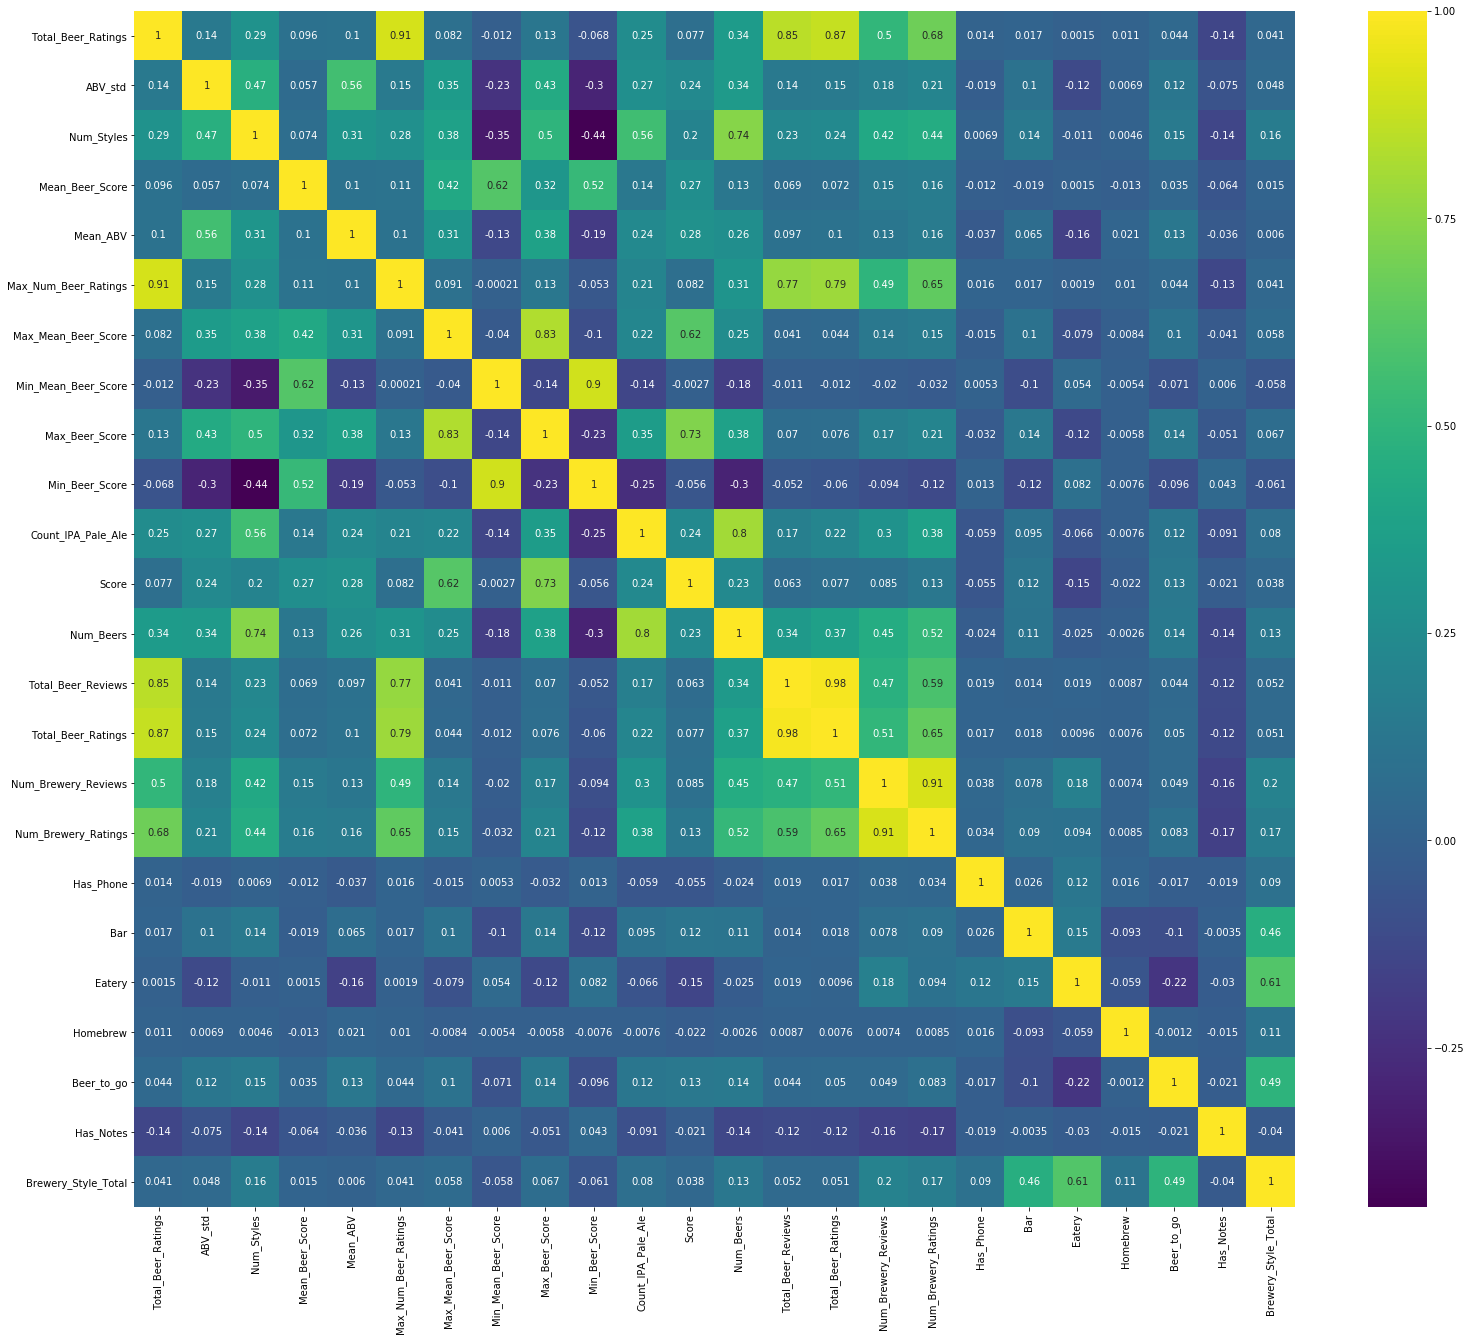

In [183]:
plt.figure(figsize=(26,22))
sns.heatmap(df_corr,cmap='viridis',annot=True);

### Imputing ABV

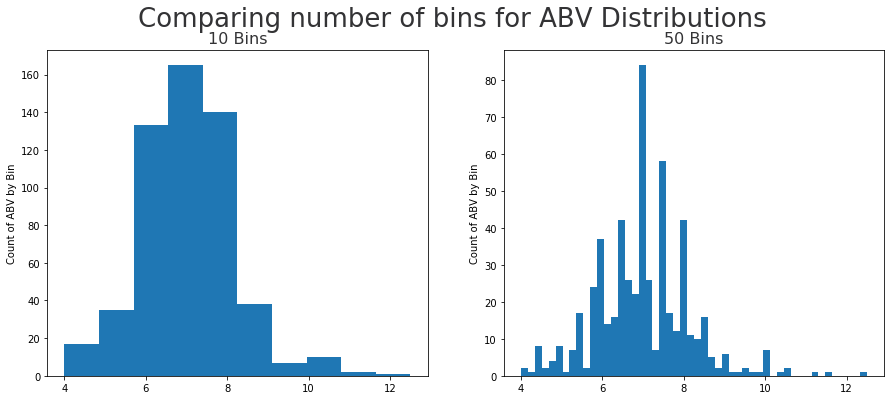

In [21]:
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(15,6))
f.suptitle('Comparing number of bins for ABV Distributions',
           fontsize=26, color='#333335')

example_abv = list(beers_df[beers_df.Beer_Style == 'Foreign / Export Stout']['ABV'])
example_abv = [x for x in example_abv if str(x) != 'nan']

ax1.set_ylabel('Count of ABV by Bin')
ax1.set_title('10 Bins',
           fontsize=16, color='#333335')
ax1.hist(example_abv,bins=10)

ax2.set_ylabel('Count of ABV by Bin')
ax2.set_title('50 Bins',
           fontsize=16, color='#333335')
ax2.hist(example_abv,bins=50);

As you can see, mean and median typically do not vary significantly.

In [22]:
Example_style_mean = beers_df[beers_df.Beer_Style == 'Foreign / Export Stout']['ABV'].mean()
Example_style_median = beers_df[beers_df.Beer_Style == 'Foreign / Export Stout']['ABV'].median()

print('See example mean v.s. example median respectively: ' + 
      str(Example_style_mean) + ' and ' + str(Example_style_median) + '.')

See example mean v.s. example median respectively: 7.005091240875916 and 7.0.


In [ ]:
beers_df['ABV'] = beers_df.groupby('Beer_Style').transform(lambda x: x.fillna(x.median()))

In [ ]:
dummies = pd.get_dummies(beers_df.Beer_Style)
beers_df = pd.concat([beers_df.Brewery_Name,dummies],axis=1)